<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных-для-машинного-обучения" data-toc-modified-id="Подготовка-данных-для-машинного-обучения-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка данных для машинного обучения</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Градиентный-бустинг" data-toc-modified-id="Градиентный-бустинг-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Градиентный бустинг</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Случайный лес</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [124]:
#импорт необходимых библиотек
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [125]:
#загружаем датасет, считываем дату и время, делаем ее индексом
data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
data = data.sort_index()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [126]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [127]:
#семплирование по одному часу
data = data.resample('1H').sum()

In [128]:
#расчет скользящего среднего для сглаживания и стандартного отклонения для проверки данных на стационарность
data['rolling_mean'] = data['num_orders'].rolling(6).mean()
data['std'] = data['num_orders'].rolling(6).std()

In [129]:
data.isna().sum()

num_orders      0
rolling_mean    5
std             5
dtype: int64

**Вывод по этапу:**
- данные загружены, дата является индексом, количество заказов такси расположено в хронологическом порядке
- созданы дополнительные столбцы скользящего среднего для сглаживания  и скользящего стандартного отклонения с шагом 6 часов

## Анализ

<AxesSubplot:xlabel='datetime'>

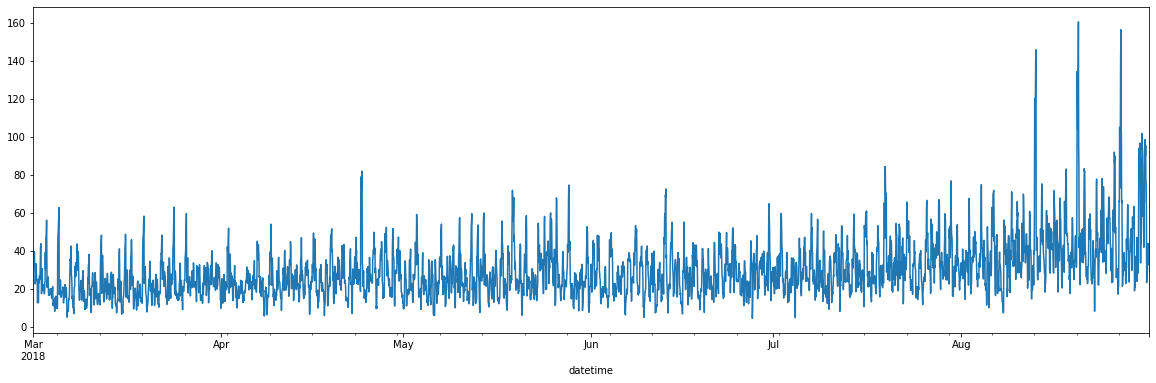

In [130]:
data['std'].plot(figsize=(20,6))

Данные не выглядят как стационарные, поскольку среднее стандартное отклонение меняется. Попробуем декомпозировать данные, чтобы посмотреть сезонность и остатки.

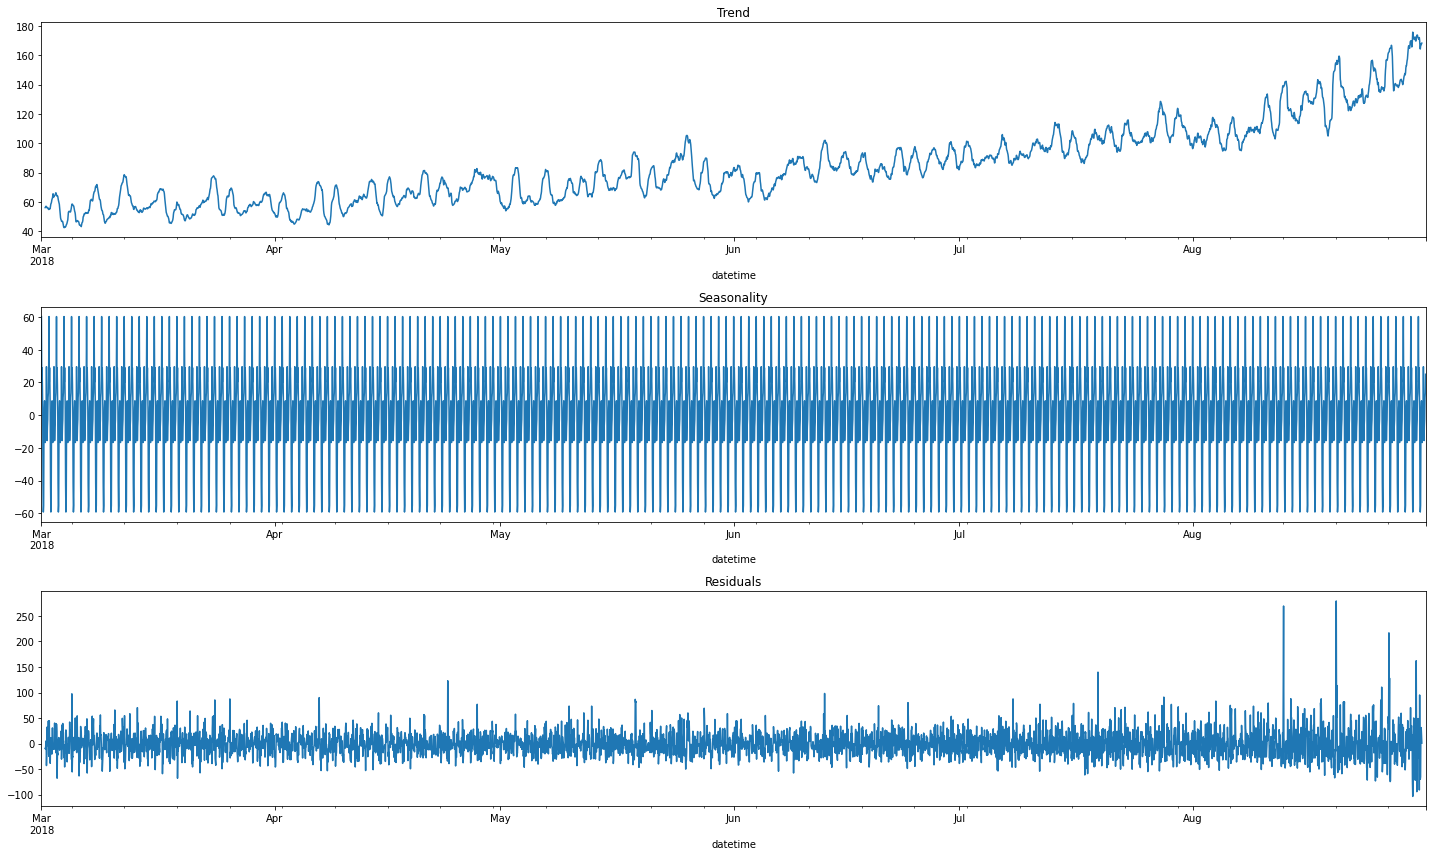

In [131]:
decomposed = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(20, 12))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

На всех данных трудно судить о сезонности. Тренд показывает общего числа заказов такси к концу лета. Это может быть связано с периодом отпусков, масштабированием самого сервиса, повышением доходов населения, расширения полетов аэропорта и т.д.

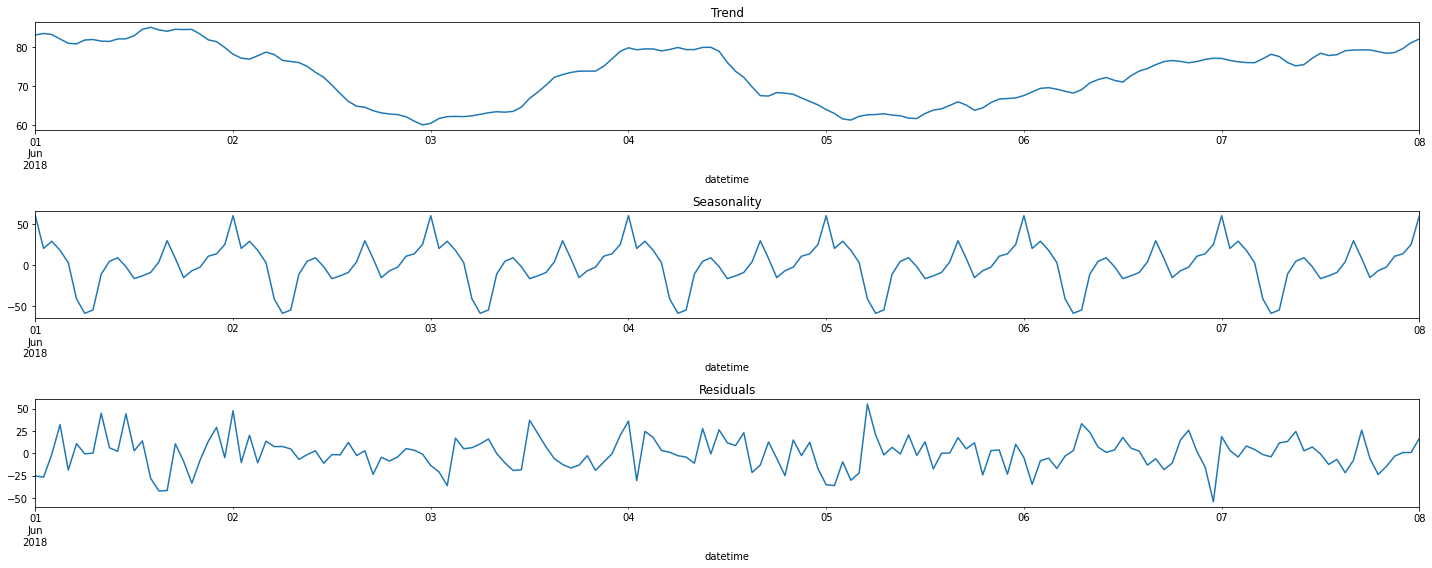

In [132]:
#недельный срез
decomposed = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(20, 8))

plt.subplot(311)
decomposed.trend['2018-06-01 00:00:00':'2018-06-08 00:00:00'].plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal['2018-06-01 00:00:00':'2018-06-08 00:00:00'].plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid['2018-06-01 00:00:00':'2018-06-08 00:00:00'].plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

Недельный срез данных демонстрирует наличие сезонности в течение дня: пики приходятся на вечернее и ночное время.

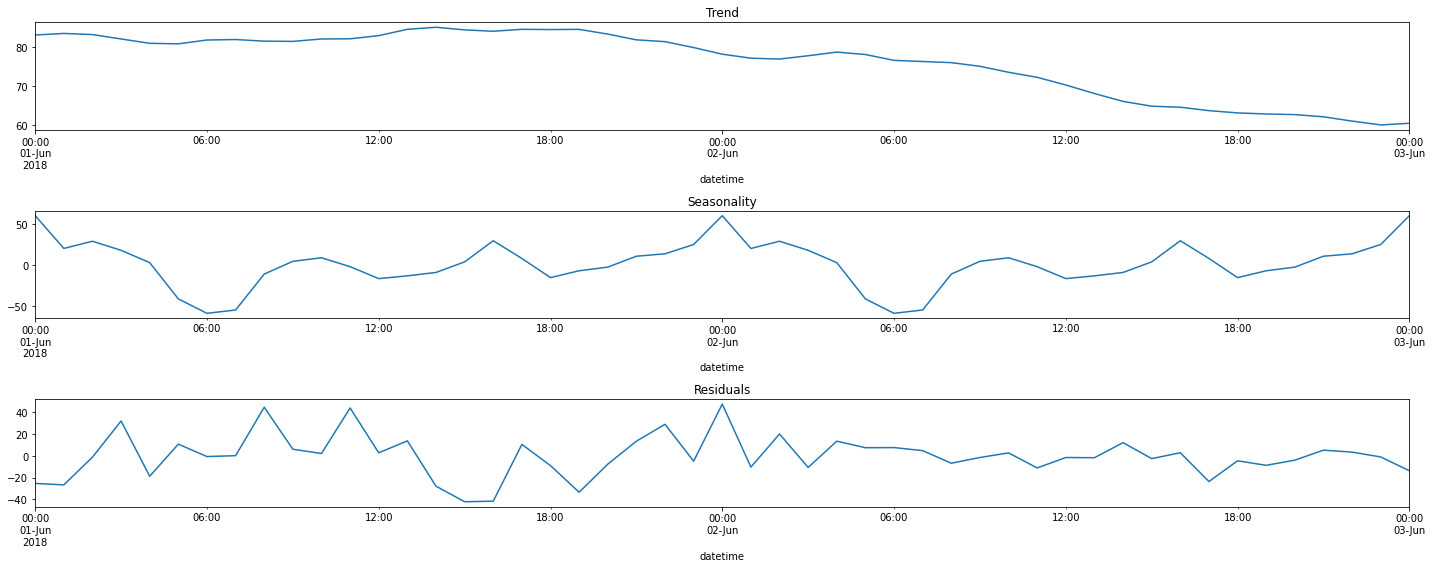

In [133]:
#двухдневный срез
decomposed = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(20, 8))

plt.subplot(311)
decomposed.trend['2018-06-01 00:00:00':'2018-06-03 00:00:00'].plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal['2018-06-01 00:00:00':'2018-06-03 00:00:00'].plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid['2018-06-01 00:00:00':'2018-06-03 00:00:00'].plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

Двухдневный срез данных демонстрирует наличие пиков в 15-16 часов и полночь следующего дня. Возможно, это связано с графиком работы общественного транспорта и прибытия самолетов. Также в этом время могут прибывать более доступные по цене рейсы и тем самым большее количество людей может сделать заказ такси.

**Выводы по этапу:**
- данные заказов нестационарные, их прогнозировать сложнее
- наблюдается сезонность заказов в 15-16 часов и ближе к полуночи

## Обучение

### Подготовка данных для машинного обучения

In [134]:
#создание функции с признаками
def make_features(data):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    #временные лаги в час, два часа, 4 часа, 6 часов, полдня, день
    hour_lags = [1, 2, 4, 6, 12, 24]
    
    for lag in hour_lags:
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(6).mean()
    
    return data

In [135]:
#прогоняем df через функцию и проверяем создание необходимых столбцов
data = make_features(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   rolling_mean  4410 non-null   float64
 2   std           4411 non-null   float64
 3   year          4416 non-null   int64  
 4   month         4416 non-null   int64  
 5   day           4416 non-null   int64  
 6   dayofweek     4416 non-null   int64  
 7   lag_1         4415 non-null   float64
 8   lag_2         4414 non-null   float64
 9   lag_4         4412 non-null   float64
 10  lag_6         4410 non-null   float64
 11  lag_12        4404 non-null   float64
 12  lag_24        4392 non-null   float64
dtypes: float64(8), int64(5)
memory usage: 483.0 KB


In [136]:
#делим данные и убираем NA в train
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

#отделяем целевой признак
target_train = train['num_orders']
train_features = train.drop(columns=['num_orders'])
target_test = test['num_orders']
test_features = test.drop(columns=['num_orders'])

In [137]:
#стандартизируем признаки
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

### Линейная регрессия

In [138]:
%%time
lin_reg = LinearRegression()
lin_reg.fit(train_features, target_train)

CPU times: user 3.35 ms, sys: 49 µs, total: 3.4 ms
Wall time: 2.11 ms


LinearRegression()

### Градиентный бустинг

In [139]:
%%time
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'num_boost_round': 500, 
    'feature_fraction': 0.75, 
    'random_state': 123, 
    'metric': 'mse',
    'learning_rate': 0.1,
    'early_stopping_round': 3,
    'max_depth': 12,
    'num_leaves': 144,
    'verbose': 2
    }

train_data = lgb.Dataset(train_features, label=target_train)
test_data = lgb.Dataset(test_features, label=target_test, reference=train_data)

light = lgb.train(params, train_data, verbose_eval=200, valid_sets=[train_data, test_data])

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.010376 seconds, init for row-wise cost 0.180058 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.275664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1696
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 11
[LightGBM] [Info] Start training from score 78.421013
[LightGBM] [Debug] Trained a tree with leaves = 144 and depth = 12
Training until validation scores don't improve for 3 rounds
[LightGBM] [Debug] Trained a tree with leaves = 144 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 144 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 144 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 144 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 144 and depth = 12
[LightGBM] [Debu

### Случайный лес

In [140]:
%%time
params = {'n_estimators': [10, 60, 100],
              'max_depth': [5, 7],
              'min_samples_split': [6,8,10]}

tscv = TimeSeriesSplit()
folds = tscv.split(train_features)
rfr = RandomForestRegressor(criterion = "mse", random_state=42, n_jobs=-1)

grid = GridSearchCV(rfr, params, cv=folds, verbose=2)
grid.fit(train_features, target_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ..max_depth=5, min_samples_split=6, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=5, min_samples_split=6, n_estimators=10; total time=   0.0s
[CV] END ..max_depth=5, min_samples_split=6, n_estimators=10; total time=   0.1s
[CV] END ..max_depth=5, min_samples_split=6, n_estimators=10; total time=   0.1s
[CV] END ..max_depth=5, min_samples_split=6, n_estimators=10; total time=   0.1s
[CV] END ..max_depth=5, min_samples_split=6, n_estimators=60; total time=   0.2s
[CV] END ..max_depth=5, min_samples_split=6, n_estimators=60; total time=   0.2s
[CV] END ..max_depth=5, min_samples_split=6, n_estimators=60; total time=   0.3s
[CV] END ..max_depth=5, min_samples_split=6, n_estimators=60; total time=   0.4s
[CV] END ..max_depth=5, min_samples_split=6, n_estimators=60; total time=   0.5s
[CV] END .max_depth=5, min_samples_split=6, n_estimators=100; total time=   0.3s
[CV] END .max_depth=5, min_samples_split=6, n_es

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f57332efeb0>,
             estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             param_grid={'max_depth': [5, 7], 'min_samples_split': [6, 8, 10],
                         'n_estimators': [10, 60, 100]},
             verbose=2)

In [141]:
best_model = grid.best_estimator_
best_model

RandomForestRegressor(max_depth=7, min_samples_split=6, n_estimators=60,
                      n_jobs=-1, random_state=42)

**Выводы по этапу:**
- созданы признаки для обучения
- обучены модели линейной регресии и градиентного бустинга, в случае со случайным лесом также произведен подбор гиперпараметров и выбрана лучшая модель
- дольше всего обучается градиентный бустинг (около 3 мин), далее идет модель случайного леса (около 31 с), затем линейная регрессия (около 4 мс)

## Тестирование

In [142]:
%%time
predictions_lr = lin_reg.predict(test_features)
print('RMSE линейной регрессии: ', mean_squared_error(target_test, predictions_lr, squared=False))

RMSE линейной регрессии:  46.873965971081645
CPU times: user 1.05 ms, sys: 0 ns, total: 1.05 ms
Wall time: 1.06 ms


In [143]:
%time
predictions_lgb = light.predict(test_features)
print('RMSE градиентного бустинга: ', mean_squared_error(target_test, predictions_lgb, squared=False))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
RMSE градиентного бустинга:  42.583868409614105


In [144]:
%time
predictions_best_rfr = best_model.predict(test_features)
print('RMSE случайного леса (лучшая модель): ', mean_squared_error(target_test, predictions_best_rfr, squared=False))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
RMSE случайного леса (лучшая модель):  43.41204075434429


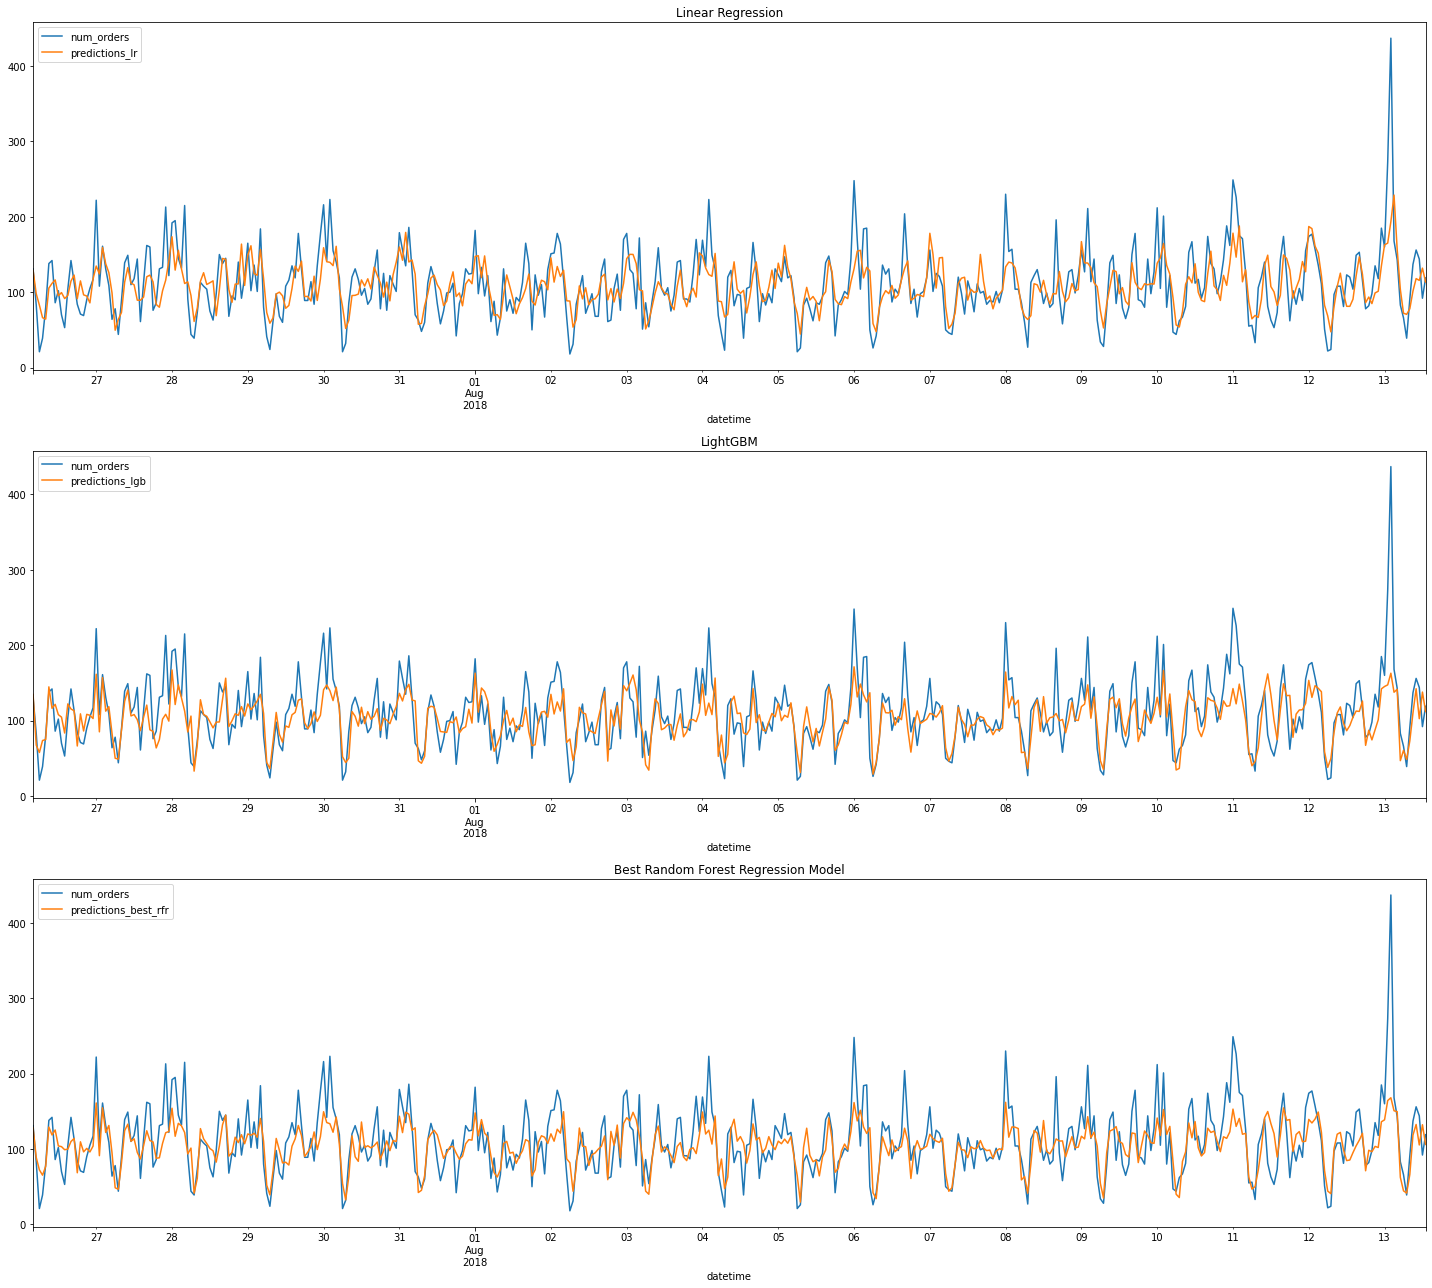

In [122]:
#создание датафрейма для визуализации
predictions_df = pd.DataFrame(
    {'predictions_lr': predictions_lr,
     'predictions_lgb': predictions_lgb,
     'predictions_best_rfr': predictions_best_rfr
    }, index=target_test.index)

predictions_df = predictions_df.join(target_test)

#визуализация
plt.figure(figsize=(20, 18))

plt.subplot(311)
predictions_df[['num_orders', 'predictions_lr']].plot(ax=plt.gca())
plt.title('Linear Regression')

plt.subplot(312)
predictions_df[['num_orders', 'predictions_lgb']].plot(ax=plt.gca())
plt.title('LightGBM')

plt.subplot(313)
predictions_df[['num_orders', 'predictions_best_rfr']].plot(ax=plt.gca())
plt.title('Best Random Forest Regression Model')

plt.tight_layout()

**Выводы по этапу:**
- быстрее всего предсказания делает LightGBM, на втором месте - случайный лес, на третьем - линейная регрессия
- все модели прошли порог RMSE не более 48, наиболее точной оказалась модель градиентного бустинга, относительно хорошие результаты также показала лучшая модель случайного леса.

**Общий вывод**

Если перед бизнесом стоит задача относительно быстрого обучения модели и прогнозирования показателей в будущем, то рекомендуется применять модель случайного леса. Если есть возможность потратить время на обучение модели и в приоритете точность предсказания, то рекомендуется обратиться к градиентному бустингу.